# 笔记

## InMemoryDataset

In [1]:
import os.path as osp

import torch
from torch_geometric.data import (InMemoryDataset, download_url)
from torch_geometric.io import read_planetoid_data

class PlanetoidPubMed(InMemoryDataset):
    r""" 节点代表文章，边代表引用关系。
   		 训练、验证和测试的划分通过二进制掩码给出。
    参数:
        root (string): 存储数据集的文件夹的路径
        transform (callable, optional): 数据转换函数，每一次获取数据时被调用。
        pre_transform (callable, optional): 数据转换函数，数据保存到文件前被调用。
    """

    url = 'https://github.com/kimiyoung/planetoid/raw/master/data'
    # url = 'https://gitee.com/rongqinchen/planetoid/raw/master/data'
    # 如果github的链接不可用，请使用gitee的链接

    def __init__(self, root, transform=None, pre_transform=None):

        super(PlanetoidPubMed, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_dir(self):
        return osp.join(self.root, 'raw')

    @property
    def processed_dir(self):
        return osp.join(self.root, 'processed')

    @property
    def raw_file_names(self):
        names = ['x', 'tx', 'allx', 'y', 'ty', 'ally', 'graph', 'test.index']
        return ['ind.pubmed.{}'.format(name) for name in names]

    @property
    def processed_file_names(self):
        return 'data.pt'

    def download(self):
        for name in self.raw_file_names:
            download_url('{}/{}'.format(self.url, name), self.raw_dir)

    def process(self):
        data = read_planetoid_data(self.raw_dir, 'pubmed')
        data = data if self.pre_transform is None else self.pre_transform(data)
        torch.save(self.collate([data]), self.processed_paths[0])

    def __repr__(self):
        return '{}()'.format(self.name)


    

In [2]:
dataset = PlanetoidPubMed('dataset/Pubmed')
print(dataset.num_classes)
print(dataset[0].num_nodes)
print(dataset[0].num_edges)
print(dataset[0].num_features)

3
19717
88648
500


## Seqential

[Sequential文档](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.sequential.Sequential)

```python
from torch.nn import Linear, ReLU
from torch_geometric.nn import Sequential, GCNConv

model = Sequential('x, edge_index', [
    (GCNConv(in_channels, 64), 'x, edge_index -> x'),
    ReLU(inplace=True),
    (GCNConv(64, 64), 'x, edge_index -> x'),
    ReLU(inplace=True),
    Linear(64, out_channels),
])
```

用法：
```
model = Sequential('x, edge_index', [
    (模型1, '模型1输入 -> 模型1返回值'),
    ReLU(inplace=True),
   (模型2, '模型2输入 -> 模型2返回值'),
    ReLU(inplace=True),
    Linear(64, out_channels),
])
```


## torch.t

## torch中@和*的作用

In [60]:
x = torch.tensor([[1,2],[3,4]])
y = torch.tensor([[2,1],[4,3]])


In [55]:
x,y,x*y#逐元素相乘

(tensor([[1, 2],
         [3, 4]]),
 tensor([[2, 1],
         [4, 3]]),
 tensor([[ 2,  2],
         [12, 12]]))

In [59]:
x,y,x@y

(tensor([[1, 2],
         [3, 4]]),
 tensor([[2, 1],
         [4, 3]]),
 tensor([[10,  7],
         [22, 15]]))

In [62]:
x,x.t(),x@x.t()#对称矩阵

(tensor([[1, 2],
         [3, 4]]),
 tensor([[1, 3],
         [2, 4]]),
 tensor([[ 5, 11],
         [11, 25]]))

In [64]:
m = torch.tensor([[1,2,3],[3,4,5],[4,5,6]])
m,m.t(),m@m.t()#对称矩阵

(tensor([[1, 2, 3],
         [3, 4, 5],
         [4, 5, 6]]),
 tensor([[1, 3, 4],
         [2, 4, 5],
         [3, 5, 6]]),
 tensor([[14, 26, 32],
         [26, 50, 62],
         [32, 62, 77]]))

## torch.cat

In [73]:
x,y,torch.cat([x,y])

(tensor([[1, 2],
         [3, 4]]),
 tensor([[2, 1],
         [4, 3]]),
 tensor([[1, 2],
         [3, 4],
         [2, 1],
         [4, 3]]))

In [74]:
x,y,torch.cat([x,y],dim=0)

(tensor([[1, 2],
         [3, 4]]),
 tensor([[2, 1],
         [4, 3]]),
 tensor([[1, 2],
         [3, 4],
         [2, 1],
         [4, 3]]))

In [75]:
x,y,torch.cat([x,y],dim=-1)

(tensor([[1, 2],
         [3, 4]]),
 tensor([[2, 1],
         [4, 3]]),
 tensor([[1, 2, 2, 1],
         [3, 4, 4, 3]]))

## 边预测decode函数解析

In [84]:

def decode(self, z, pos_edge_index, neg_edge_index):
    edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)
    return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)




`z[edge_index[0]] ` 是所有起始节点的表征
`z[edge_index[1]]` 是所有终止节点的表征

# 作业

## 实践问题一：尝试使用PyG中的不同的网络层去代替`GCNConv`，以及不同的层数和不同的`out_channels`，来实现节点分类任务。

In [10]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import torch

from torch.nn import Linear
from torch_geometric.nn import GATConv
from torch.nn import Linear, ReLU
from torch_geometric.nn import Sequential, GCNConv



import torch.nn.functional as F

In [4]:
from tqdm import tqdm
from time import time
class Model(torch.nn.Module):
    def __init__(self,optimizer=None,criterion=None,**kwargs):
        super(Model, self).__init__()
        self.optimizer=optimizer
        self.criterion=criterion
        
    def _train(self,data,epoch=200):
        def _loss():
            self.train()
            self.optimizer.zero_grad()  # Clear gradients.
            if self.forward.__code__.co_argcount == 2:
                out = self.forward(data.x)  # Perform a single forward pass.
            elif self.forward.__code__.co_argcount == 3:
                out = self.forward(data.x, data.edge_index)
            loss = self.criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
            loss.backward()  # Derive gradients.
            self.optimizer.step()  # Update parameters based on gradients.
            return loss
        t0=time()
        for i in tqdm(range(epoch)):
            loss = _loss()
            if i+1>epoch-10:
                print(f'Epoch: {i+1:03d}, Loss: {loss:.4f}')
        self.time = time()-t0


    def _test(self,data):
        def __test():
            self.eval()
            if self.forward.__code__.co_argcount == 2:
                self.out = self.forward(data.x)
            elif self.forward.__code__.co_argcount == 3:
                self.out = self.forward(data.x, data.edge_index)
            pred = self.out.argmax(dim=1)  # Use the class with highest probability.
            test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
            test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
            return test_acc

        test_acc = __test()
        self.test_acc=test_acc
        print(f'Test Accuracy: {test_acc:.4f}')
        
    def _visualize(self,data):
        def __visualize(out, color):
            z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())
            plt.figure(figsize=(10,10))
            plt.xticks([])
            plt.yticks([])

            plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
            plt.show()

            
        self.eval()
        if self.forward.__code__.co_argcount == 2:
            self.out = self(data.x)
        elif self.forward.__code__.co_argcount == 3:
            self.out = self.forward(data.x, data.edge_index)
        
        __visualize(self.out, color=data.y)

In [5]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='dataset/Cora', name='Cora', transform=NormalizeFeatures())

data = dataset[0]  # Get the first graph object.
#describe_dataset(dataset)

### GAT



In [6]:
class GAT(Model):
    def __init__(self, num_features, hidden_channels_list, num_classes):
        super(GAT, self).__init__()
        torch.manual_seed(12345)
        hns = [num_features] + hidden_channels_list
        conv_list = []
        for idx in range(len(hidden_channels_list)):
            conv_list.append((GATConv(hns[idx], hns[idx+1]), 'x, edge_index -> x'))
            conv_list.append(ReLU(inplace=True),)

        self.convseq = Sequential('x, edge_index', conv_list)
        self.linear = Linear(hidden_channels_list[-1], num_classes)

    def forward(self, x, edge_index):
        x = self.convseq(x, edge_index)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear(x)
        return x


In [11]:

model=GAT(data.num_features,[16,16,16],dataset.num_classes)
model.criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
model.optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.


In [12]:
model._train(data)

 97%|█████████▋| 194/200 [00:10<00:00, 20.17it/s]

Epoch: 191, Loss: 0.1621
Epoch: 192, Loss: 0.2263
Epoch: 193, Loss: 0.2324
Epoch: 194, Loss: 0.2828
Epoch: 195, Loss: 0.3554


100%|██████████| 200/200 [00:11<00:00, 17.80it/s]

Epoch: 196, Loss: 0.2219
Epoch: 197, Loss: 0.2132
Epoch: 198, Loss: 0.2591
Epoch: 199, Loss: 0.2039
Epoch: 200, Loss: 0.2196


In [14]:
model._test(data)

Test Accuracy: 0.6480


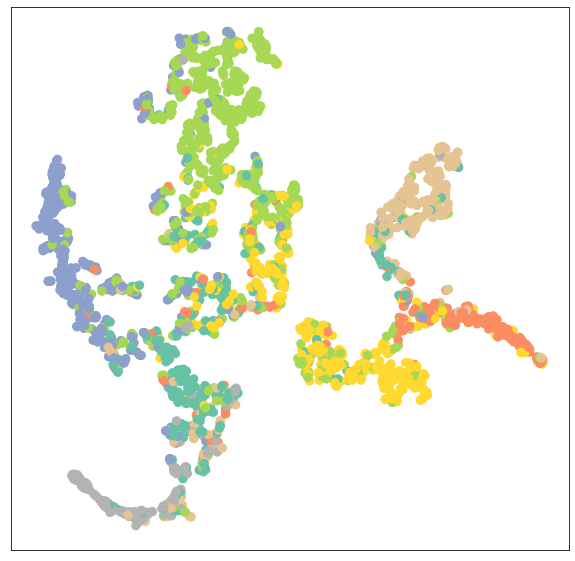

In [15]:
model._visualize(data)

In [16]:

model=GAT(data.num_features,[100],dataset.num_classes)
model.criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
model.optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

model._train(data)

 97%|█████████▋| 194/200 [00:10<00:00, 18.52it/s]

Epoch: 191, Loss: 0.0649
Epoch: 192, Loss: 0.0728
Epoch: 193, Loss: 0.0665
Epoch: 194, Loss: 0.0737


 99%|█████████▉| 198/200 [00:10<00:00, 18.25it/s]

Epoch: 195, Loss: 0.0810
Epoch: 196, Loss: 0.0839
Epoch: 197, Loss: 0.0880
Epoch: 198, Loss: 0.0720


100%|██████████| 200/200 [00:10<00:00, 18.63it/s]

Epoch: 199, Loss: 0.0738
Epoch: 200, Loss: 0.0763


In [18]:
model._test(data)

Test Accuracy: 0.6620


### SAGE

In [19]:
from torch_geometric.nn import SAGEConv

class SAGE(Model):
    def __init__(self, num_features, hidden_channels_list, num_classes):
        super(SAGE, self).__init__()
        torch.manual_seed(12345)
        conv_list = []
        hns = [num_features]+hidden_channels_list
        for idx in range(len(hidden_channels_list)):
            conv_list.append((SAGEConv(hns[idx], hns[idx+1]),'x, edge_index -> x'))
            conv_list.append(ReLU(inplace=True))
        self.convseq = Sequential('x, edge_index', conv_list)
        self.linear = Linear(hidden_channels_list[-1], num_classes)

    def forward(self, x, edge_index):
        x = self.convseq(x, edge_index)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear(x)
        return x
    


In [20]:

model=SAGE(data.num_features,[16,10],dataset.num_classes)
model.criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
model.optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

model._train(data)

 96%|█████████▌| 191/200 [00:57<00:02,  3.39it/s]

Epoch: 191, Loss: 0.5513


 96%|█████████▌| 192/200 [00:57<00:02,  3.39it/s]

Epoch: 192, Loss: 0.5344


 96%|█████████▋| 193/200 [00:57<00:02,  3.39it/s]

Epoch: 193, Loss: 0.4957


 97%|█████████▋| 194/200 [00:57<00:01,  3.35it/s]

Epoch: 194, Loss: 0.5239


 98%|█████████▊| 195/200 [00:58<00:01,  3.36it/s]

Epoch: 195, Loss: 0.4863


 98%|█████████▊| 196/200 [00:58<00:01,  3.37it/s]

Epoch: 196, Loss: 0.4856


 98%|█████████▊| 197/200 [00:58<00:00,  3.37it/s]

Epoch: 197, Loss: 0.5190


 99%|█████████▉| 198/200 [00:59<00:00,  3.38it/s]

Epoch: 198, Loss: 0.4684


100%|█████████▉| 199/200 [00:59<00:00,  3.38it/s]

Epoch: 199, Loss: 0.3953


100%|██████████| 200/200 [00:59<00:00,  3.35it/s]

Epoch: 200, Loss: 0.4544


In [21]:
model._test(data)

Test Accuracy: 0.6460


In [22]:

model=SAGE(data.num_features,[100],dataset.num_classes)
model.criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
model.optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

model._train(data)

 96%|█████████▌| 191/200 [01:00<00:02,  3.18it/s]

Epoch: 191, Loss: 0.0752


 96%|█████████▌| 192/200 [01:00<00:02,  3.18it/s]

Epoch: 192, Loss: 0.0628


 96%|█████████▋| 193/200 [01:00<00:02,  3.18it/s]

Epoch: 193, Loss: 0.0651


 97%|█████████▋| 194/200 [01:01<00:01,  3.18it/s]

Epoch: 194, Loss: 0.0631


 98%|█████████▊| 195/200 [01:01<00:01,  3.18it/s]

Epoch: 195, Loss: 0.0601


 98%|█████████▊| 196/200 [01:01<00:01,  3.18it/s]

Epoch: 196, Loss: 0.0560


 98%|█████████▊| 197/200 [01:01<00:00,  3.18it/s]

Epoch: 197, Loss: 0.0743


 99%|█████████▉| 198/200 [01:02<00:00,  3.18it/s]

Epoch: 198, Loss: 0.0673


100%|█████████▉| 199/200 [01:02<00:00,  3.19it/s]

Epoch: 199, Loss: 0.0701


100%|██████████| 200/200 [01:02<00:00,  3.18it/s]

Epoch: 200, Loss: 0.0662


In [23]:
model._test(data)

Test Accuracy: 0.7300


In [24]:

model=SAGE(data.num_features,[50,50],dataset.num_classes)
model.criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
model.optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

model._train(data)

 96%|█████████▌| 191/200 [00:59<00:02,  3.22it/s]

Epoch: 191, Loss: 0.0326


 96%|█████████▌| 192/200 [00:59<00:02,  3.21it/s]

Epoch: 192, Loss: 0.0254


 96%|█████████▋| 193/200 [01:00<00:02,  3.21it/s]

Epoch: 193, Loss: 0.0364


 97%|█████████▋| 194/200 [01:00<00:01,  3.22it/s]

Epoch: 194, Loss: 0.0297


 98%|█████████▊| 195/200 [01:00<00:01,  3.21it/s]

Epoch: 195, Loss: 0.0298


 98%|█████████▊| 196/200 [01:01<00:01,  3.20it/s]

Epoch: 196, Loss: 0.0323


 98%|█████████▊| 197/200 [01:01<00:00,  3.21it/s]

Epoch: 197, Loss: 0.0308


 99%|█████████▉| 198/200 [01:01<00:00,  3.21it/s]

Epoch: 198, Loss: 0.0225


100%|█████████▉| 199/200 [01:02<00:00,  3.21it/s]

Epoch: 199, Loss: 0.0396


100%|██████████| 200/200 [01:02<00:00,  3.21it/s]

Epoch: 200, Loss: 0.0239


In [25]:
model._test(data)

Test Accuracy: 0.7900


In [26]:

model=SAGE(data.num_features,[100,100],dataset.num_classes)
model.criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
model.optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

model._train(data)

 96%|█████████▌| 191/200 [01:03<00:03,  2.99it/s]

Epoch: 191, Loss: 0.0167


 96%|█████████▌| 192/200 [01:04<00:02,  2.99it/s]

Epoch: 192, Loss: 0.0177


 96%|█████████▋| 193/200 [01:04<00:02,  2.98it/s]

Epoch: 193, Loss: 0.0195


 97%|█████████▋| 194/200 [01:04<00:02,  2.97it/s]

Epoch: 194, Loss: 0.0188


 98%|█████████▊| 195/200 [01:05<00:01,  2.98it/s]

Epoch: 195, Loss: 0.0179


 98%|█████████▊| 196/200 [01:05<00:01,  2.98it/s]

Epoch: 196, Loss: 0.0167


 98%|█████████▊| 197/200 [01:05<00:01,  2.98it/s]

Epoch: 197, Loss: 0.0139


 99%|█████████▉| 198/200 [01:06<00:00,  2.98it/s]

Epoch: 198, Loss: 0.0142


100%|█████████▉| 199/200 [01:06<00:00,  2.98it/s]

Epoch: 199, Loss: 0.0186


100%|██████████| 200/200 [01:06<00:00,  2.99it/s]

Epoch: 200, Loss: 0.0144


In [27]:
model._test(data)

Test Accuracy: 0.7500


In [28]:

model=SAGE(data.num_features,[50,50,50],dataset.num_classes)
model.criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
model.optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

model._train(data)
model._test(data)

 96%|█████████▌| 191/200 [01:01<00:02,  3.11it/s]

Epoch: 191, Loss: 0.0531


 96%|█████████▌| 192/200 [01:01<00:02,  3.11it/s]

Epoch: 192, Loss: 0.0166


 96%|█████████▋| 193/200 [01:02<00:02,  3.11it/s]

Epoch: 193, Loss: 0.0435


 97%|█████████▋| 194/200 [01:02<00:01,  3.10it/s]

Epoch: 194, Loss: 0.0350


 98%|█████████▊| 195/200 [01:02<00:01,  3.04it/s]

Epoch: 195, Loss: 0.0312


 98%|█████████▊| 196/200 [01:03<00:01,  3.05it/s]

Epoch: 196, Loss: 0.0192


 98%|█████████▊| 197/200 [01:03<00:00,  3.06it/s]

Epoch: 197, Loss: 0.0197


 99%|█████████▉| 198/200 [01:03<00:00,  3.08it/s]

Epoch: 198, Loss: 0.0195


100%|█████████▉| 199/200 [01:04<00:00,  3.08it/s]

Epoch: 199, Loss: 0.0194


100%|██████████| 200/200 [01:04<00:00,  3.10it/s]

Epoch: 200, Loss: 0.0345


Test Accuracy: 0.7600


In [29]:

model=SAGE(data.num_features,[20,20,20],dataset.num_classes)
model.criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
model.optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

model._train(data,epoch=200)
model._test(data)

 96%|█████████▌| 191/200 [00:58<00:02,  3.30it/s]

Epoch: 191, Loss: 0.3009


 96%|█████████▌| 192/200 [00:58<00:02,  3.28it/s]

Epoch: 192, Loss: 0.3941


 96%|█████████▋| 193/200 [00:58<00:02,  3.29it/s]

Epoch: 193, Loss: 0.3114


 97%|█████████▋| 194/200 [00:59<00:01,  3.29it/s]

Epoch: 194, Loss: 0.3474


 98%|█████████▊| 195/200 [00:59<00:01,  3.30it/s]

Epoch: 195, Loss: 0.2643


 98%|█████████▊| 196/200 [00:59<00:01,  3.30it/s]

Epoch: 196, Loss: 0.3942


 98%|█████████▊| 197/200 [01:00<00:00,  3.30it/s]

Epoch: 197, Loss: 0.3522


 99%|█████████▉| 198/200 [01:00<00:00,  3.30it/s]

Epoch: 198, Loss: 0.2413


100%|█████████▉| 199/200 [01:00<00:00,  3.24it/s]

Epoch: 199, Loss: 0.3972


100%|██████████| 200/200 [01:00<00:00,  3.28it/s]

Epoch: 200, Loss: 0.2662


Test Accuracy: 0.5900


## 实践问题二：在边预测任务中，尝试用`torch_geometric.nn.Sequential`容器构造图神经网络。


### 教程代码试运行

In [ ]:


import os.path as osp

from torch_geometric.utils import negative_sampling
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.utils import train_test_split_edges

dataset = Planetoid('dataset/Cora', 'Cora', transform=T.NormalizeFeatures())
data = dataset[0]
data.train_mask = data.val_mask = data.test_mask = data.y = None # 不再有用

print(data.edge_index.shape)
# torch.Size([2, 10556])

data = train_test_split_edges(data)

for key in data.keys:
    print(key, getattr(data, key).shape)

# x torch.Size([2708, 1433])
# val_pos_edge_index torch.Size([2, 263])
# test_pos_edge_index torch.Size([2, 527])
# train_pos_edge_index torch.Size([2, 8976])
# train_neg_adj_mask torch.Size([2708, 2708])
# val_neg_edge_index torch.Size([2, 263])
# test_neg_edge_index torch.Size([2, 527])
# 263 + 527 + 8976 = 9766 != 10556
# 263 + 527 + 8976/2 = 5278 = 10556/2

In [33]:
import torch
from torch_geometric.nn import GCNConv

class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Net, self).__init__()
        self.conv1 = GCNConv(in_channels, 128)
        self.conv2 = GCNConv(128, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        return self.conv2(x, edge_index)

    def decode(self, z, pos_edge_index, neg_edge_index):
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()



In [34]:
def get_link_labels(pos_edge_index, neg_edge_index):
    num_links = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(num_links, dtype=torch.float)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels

def train(data, model, optimizer):
    model.train()

    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=data.train_pos_edge_index.size(1))

    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    link_logits = model.decode(z, data.train_pos_edge_index, neg_edge_index)
    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index).to(data.x.device)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()

    return loss



In [35]:
@torch.no_grad()
def test(data, model):
    model.eval()

    z = model.encode(data.x, data.train_pos_edge_index)

    results = []
    for prefix in ['val', 'test']:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']
        link_logits = model.decode(z, pos_edge_index, neg_edge_index)
        link_probs = link_logits.sigmoid()
        link_labels = get_link_labels(pos_edge_index, neg_edge_index)
        results.append(roc_auc_score(link_labels.cpu(), link_probs.cpu()))
    return results



In [36]:

from logging import root
import os.path as osp

import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from sklearn.metrics import roc_auc_score
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling, train_test_split_edges



In [37]:
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    dataset = 'Cora'
    #path = osp.join(osp.dirname(osp.realpath(__file__)), '.', 'dataset', dataset)
    dataset = Planetoid('./dataset/Cora', dataset, transform=NormalizeFeatures())
    data = dataset[0]
    #ground_truth_edge_index = data.edge_index.to(device)
    data.train_mask = data.val_mask = data.test_mask = data.y = None
    data = train_test_split_edges(data)
    #data = data.to(device)

    model = Net(dataset.num_features, 64)#.to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

    best_val_auc = test_auc = 0
    for epoch in range(1, 101):
        loss = train(data, model, optimizer)
        val_auc, tmp_test_auc = test(data, model)
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            test_auc = tmp_test_auc
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
              f'Test: {test_auc:.4f}')

    z = model.encode(data.x, data.train_pos_edge_index)
    final_edge_index = model.decode_all(z)


if __name__ == "__main__":
    main()



Epoch: 001, Loss: 0.6930, Val: 0.7185, Test: 0.6651
Epoch: 002, Loss: 0.6810, Val: 0.7098, Test: 0.6651
Epoch: 003, Loss: 0.7166, Val: 0.7193, Test: 0.6629
Epoch: 004, Loss: 0.6768, Val: 0.7393, Test: 0.6767
Epoch: 005, Loss: 0.6849, Val: 0.7797, Test: 0.7122
Epoch: 006, Loss: 0.6890, Val: 0.8133, Test: 0.7473
Epoch: 007, Loss: 0.6905, Val: 0.7832, Test: 0.7473
Epoch: 008, Loss: 0.6906, Val: 0.7526, Test: 0.7473
Epoch: 009, Loss: 0.6896, Val: 0.7414, Test: 0.7473
Epoch: 010, Loss: 0.6872, Val: 0.7382, Test: 0.7473
Epoch: 011, Loss: 0.6829, Val: 0.7367, Test: 0.7473
Epoch: 012, Loss: 0.6783, Val: 0.7329, Test: 0.7473
Epoch: 013, Loss: 0.6781, Val: 0.7329, Test: 0.7473
Epoch: 014, Loss: 0.6773, Val: 0.7338, Test: 0.7473
Epoch: 015, Loss: 0.6696, Val: 0.7336, Test: 0.7473
Epoch: 016, Loss: 0.6640, Val: 0.7310, Test: 0.7473
Epoch: 017, Loss: 0.6603, Val: 0.7293, Test: 0.7473
Epoch: 018, Loss: 0.6546, Val: 0.7271, Test: 0.7473
Epoch: 019, Loss: 0.6467, Val: 0.7273, Test: 0.7473
Epoch: 020, 

### Sequential实现

In [38]:
import torch
from torch_geometric.nn import GCNConv

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels_list, out_channels):
        super(Net, self).__init__()
        hns = [in_channels]+hidden_channels_list
        conv_list = []
        for i in range(len(hns)-1):
            conv_list.append(
                (GCNConv(hns[i], hns[i+1]),'x, edge_index -> x')
            )
            conv_list.append(ReLU(inplace=True))

        self.convseq = Sequential('x, edge_index', conv_list)
        self.linear = Linear(hidden_channels_list[-1], out_channels)

    def encode(self, x, edge_index):
        
        x = self.convseq(x, edge_index)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear(x)
        return x

    def decode(self, z, pos_edge_index, neg_edge_index):
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()




In [39]:
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    dataset = 'Cora'
    #path = osp.join(osp.dirname(osp.realpath(__file__)), '.', 'dataset', dataset)
    dataset = Planetoid('./dataset/Cora', dataset, transform=NormalizeFeatures())
    data = dataset[0]
    #ground_truth_edge_index = data.edge_index.to(device)
    data.train_mask = data.val_mask = data.test_mask = data.y = None
    data = train_test_split_edges(data)
    #data = data.to(device)

    model = Net(dataset.num_features,[128], 64)#.to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

    best_val_auc = test_auc = 0
    for epoch in range(1, 101):
        loss = train(data, model, optimizer)
        val_auc, tmp_test_auc = test(data, model)
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            test_auc = tmp_test_auc
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
              f'Test: {test_auc:.4f}')

    z = model.encode(data.x, data.train_pos_edge_index)
    final_edge_index = model.decode_all(z)


if __name__ == "__main__":
    main()




Epoch: 001, Loss: 0.6975, Val: 0.6611, Test: 0.6266
Epoch: 002, Loss: 0.6938, Val: 0.7014, Test: 0.6854
Epoch: 003, Loss: 0.6911, Val: 0.7041, Test: 0.6968
Epoch: 004, Loss: 0.6873, Val: 0.7039, Test: 0.6968
Epoch: 005, Loss: 0.6832, Val: 0.7012, Test: 0.6968
Epoch: 006, Loss: 0.6769, Val: 0.7013, Test: 0.6968
Epoch: 007, Loss: 0.6705, Val: 0.7074, Test: 0.6932
Epoch: 008, Loss: 0.6611, Val: 0.7033, Test: 0.6932
Epoch: 009, Loss: 0.6535, Val: 0.7091, Test: 0.6915
Epoch: 010, Loss: 0.6451, Val: 0.7155, Test: 0.6900
Epoch: 011, Loss: 0.6392, Val: 0.7150, Test: 0.6900
Epoch: 012, Loss: 0.6431, Val: 0.7205, Test: 0.6834
Epoch: 013, Loss: 0.6298, Val: 0.7301, Test: 0.6904
Epoch: 014, Loss: 0.6256, Val: 0.7340, Test: 0.6989
Epoch: 015, Loss: 0.6209, Val: 0.7410, Test: 0.6998
Epoch: 016, Loss: 0.6129, Val: 0.7444, Test: 0.6919
Epoch: 017, Loss: 0.6095, Val: 0.7496, Test: 0.6960
Epoch: 018, Loss: 0.6026, Val: 0.7592, Test: 0.7079
Epoch: 019, Loss: 0.5945, Val: 0.7649, Test: 0.7115
Epoch: 020, 

## 思考问题三：如下方代码所示，我们以`data.train_pos_edge_index`为实际参数来进行训练集负样本采样，但这样采样得到的负样本可能包含一些验证集的正样本与测试集的正样本，即可能将真实的正样本标记为负样本，由此会产生冲突。但我们还是这么做，这是为什么？

In [ ]:
neg_edge_index = negative_sampling(
    edge_index=data.train_pos_edge_index,
    num_nodes=data.num_nodes,
    num_neg_samples=data.train_pos_edge_index.size(1))

### 思考题探究过程

#### 负样本中labels全为0，包括可能为验证集和测试集中正样本的样本

In [44]:
model = Net(dataset.num_features,[128], 64)#.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

z = model.encode(data.x, data.train_pos_edge_index)

In [83]:
z[c[0]].shape

torch.Size([1054, 64])

In [79]:
pos_edge_index = data['test_pos_edge_index']
neg_edge_index = data['test_neg_edge_index']
c = torch.cat([pos_edge_index, neg_edge_index], dim=-1)

In [67]:
pos_edge_index

tensor([[ 756, 1838,   13,  ...,  143,  735, 1233],
        [ 885, 2182, 1701,  ...,  598, 2061, 2433]])

In [88]:
link_logits = model.decode(z, data.train_pos_edge_index, neg_edge_index)

In [89]:
link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index).to(data.x.device)
loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)

In [91]:
link_labels

tensor([1., 1., 1.,  ..., 0., 0., 0.])

In [94]:
neg_edge_index.shape

torch.Size([2, 527])

In [95]:
link_labels[-527:]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 